<h2>Load and preprocess an image dataset in three ways<h2/>

# Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.3.0


# Download the flowers dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 3s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


# Enter downloaded folder and view

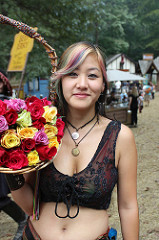

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

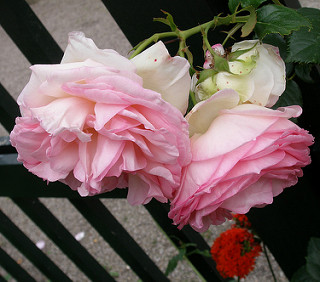

In [6]:
PIL.Image.open(str(roses[1]))

# 1. Load using keras.preprocessing

## Create a dataset

In [7]:
batch_size = 32
img_height = 180
img_width =180

*It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation*

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

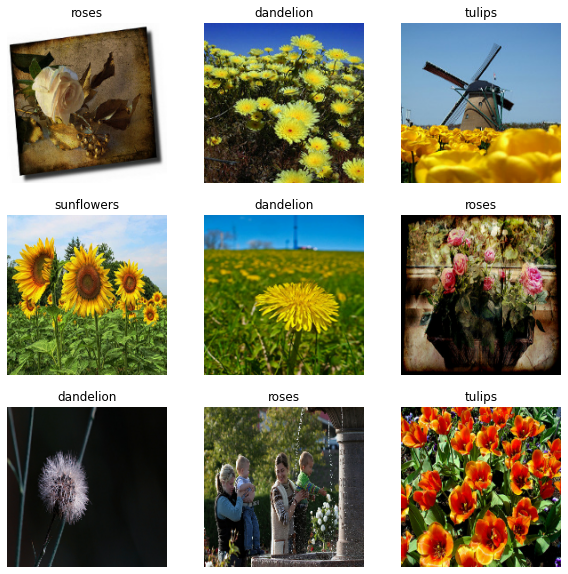

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**You can train a model using these datasets by passing them to model.fit (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:**

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


*The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.*

## Standardize the data

In [14]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

**There are two ways to use this layer. You can apply it to the dataset by calling map:**

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

**Or, you can include the layer inside your model definition to simplify deployment. We will use the second approach here.**

## Configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train a model

*For completeness, we will show how to train a simple model using the datasets we just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created.*

In [16]:
num_classes = 5
model = tf.keras.Sequential([
                            layers.experimental.preprocessing.Rescaling(1./255),
                            layers.Conv2D(32,3, activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Conv2D(32, 3, activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Conv2D(32, 3, activation='relu'),
                            layers.MaxPooling2D(),
                            layers.Flatten(),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(num_classes)                             
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [17]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
92/92 [==============================] - 111s 1s/step - loss: 1.2732 - accuracy: 0.4516 - val_loss: 1.0821 - val_accuracy: 0.5668
Epoch 2/5
92/92 [==============================] - 108s 1s/step - loss: 1.0539 - accuracy: 0.5702 - val_loss: 1.0257 - val_accuracy: 0.5708
Epoch 3/5
92/92 [==============================] - 105s 1s/step - loss: 0.9065 - accuracy: 0.6400 - val_loss: 0.9681 - val_accuracy: 0.6090
Epoch 4/5
92/92 [==============================] - 105s 1s/step - loss: 0.7530 - accuracy: 0.7088 - val_loss: 0.9147 - val_accuracy: 0.6458
Epoch 5/5
92/92 [==============================] - 106s 1s/step - loss: 0.5596 - accuracy: 0.7973 - val_loss: 1.0978 - val_accuracy: 0.6253


# 2. Using tf.data for finer control

*The above keras.preprocessing utilities are a convenient way to create a tf.data.Dataset from a directory of images. For finer grain control, you can write your own input pipeline using tf.data. This section shows how to do just that, beginning with the file paths from the zip we downloaded earlier.*

In [18]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [19]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/14957470_6a8c272a87_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3699235066_fc09a02dfe_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/9188647508_3b56e62f69.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/7184780734_3baab127c2_m.jpg'
b'/root/.keras/datasets/flower_photos/roses/6163179241_f093f45d95_n.jpg'


## Get the classname 

In [20]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


## Split the dataset into train and validation

In [21]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


## Write a short function that converts a file path to an (img, label) pair

In [23]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


**Use Dataset.map to create a dataset of image, label pairs:**

In [24]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


## Configure dataset for performance

In [26]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Visualize the data

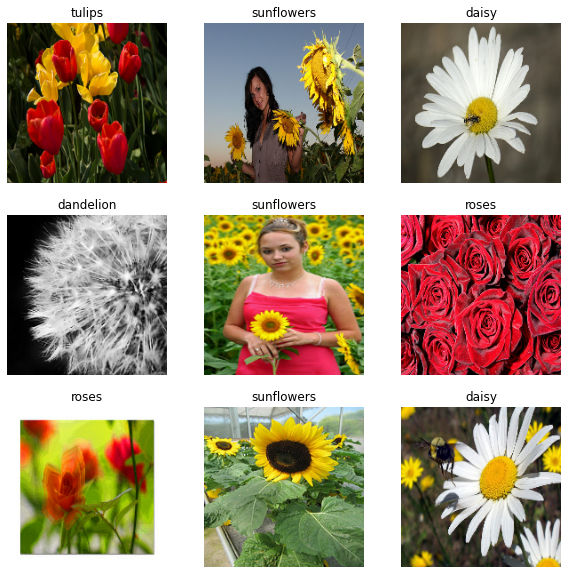

In [27]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Continue training the model

In [28]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 111s 1s/step - loss: 0.5507 - accuracy: 0.7997 - val_loss: 0.5579 - val_accuracy: 0.7902
Epoch 2/3
92/92 [==============================] - 106s 1s/step - loss: 0.3569 - accuracy: 0.8750 - val_loss: 0.6776 - val_accuracy: 0.7766
Epoch 3/3
92/92 [==============================] - 109s 1s/step - loss: 0.2356 - accuracy: 0.9189 - val_loss: 0.6170 - val_accuracy: 0.8011


# 3. Using TensorFlow Datasets

So far, this tutorial has focused on loading data off disk. You can also find a dataset to use by exploring the large catalog of easy-to-download datasets at TensorFlow Datasets. As you have previously loaded the Flowers dataset off disk, let's see how to import it with TensorFlow Datasets.

Download the flowers dataset using TensorFlow Datasets.

In [29]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [30]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


**Retrieve an image from the dataset**

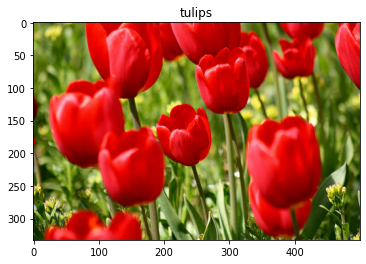

In [31]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

**As before, remember to batch, shuffle, and configure each dataset for performance.**

In [32]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)